In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('seaborn')
torch.manual_seed(2019)

In [26]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [27]:
#vgg16 use 224x224 images

In [28]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      #augmentation
                                      transforms.RandomHorizontalFlip(),
                                      #transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      #aug end
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                               ])

transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])

In [29]:
training_dataset = datasets.ImageFolder(root='./data/ants_and_bees/train', transform=transform_train)
validation_dataset = datasets.ImageFolder(root='./data/ants_and_bees/val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)

In [30]:
training_dataset

Dataset ImageFolder
    Number of datapoints: 244
    Root Location: ./data/ants_and_bees/train
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             RandomAffine(degrees=(0, 0), scale=(0.8, 1.2), shear=(-10, 10))
                             ColorJitter(brightness=[0, 2], contrast=[0, 2], saturation=[0, 2], hue=None)
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None

In [31]:
#convert from tensor to numpy
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() # (1,32,32)
    image = image.transpose(1, 2, 0) # (32,32,1)
    image = image * np.array((.5, .5, .5)) + np.array((.5, .5, .5)) #denormalize
    image = image.clip(0, 1)
    return image

In [32]:
classes = ('ant', 'bee') #respect the order of folders

In [33]:
dataiter = iter(training_loader)
images, labels = dataiter.next()

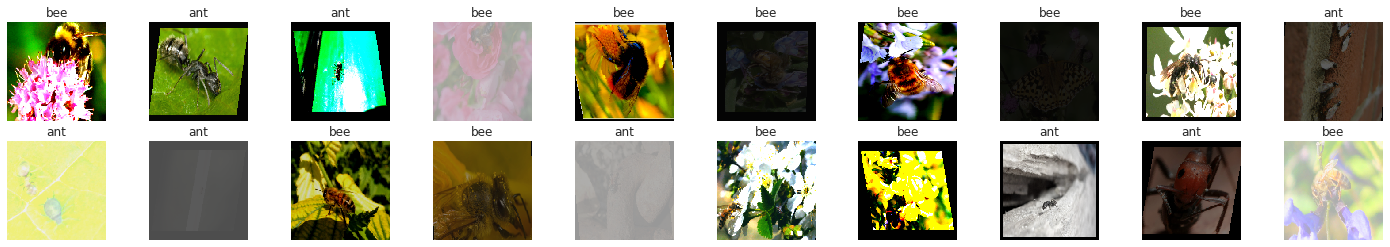

In [34]:
#Plot some images
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [51]:
# model = models.alexnet(pretrained=True)
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/canivel/.torch/models/vgg16-397923af.pth
553433881it [00:44, 12361461.51it/s]


In [52]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [53]:
#freeze the (features) params before the FCs
for param in model.features.parameters():
    param.requires_grad = False

In [54]:
n_inputs = model.classifier[6].in_features #6th layer of the classifier
#create the last FC
last_fc = nn.Linear(in_features=n_inputs, out_features=len(classes))
#replacing the last layer by ours with 2 classes
model.classifier[6] = last_fc
model.to(device)#if gpu is available is great
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [55]:
criterion = nn.CrossEntropyLoss() # used for multiclass classification
optmizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [56]:
epochs = 5
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

for epoch in range(epochs):
    #each training batch
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs) # return proba for each class (score)
        loss = criterion(outputs, labels)
        
        optmizer.zero_grad()
        loss.backward()
        optmizer.step()
        
        #max score output class
        _, preds = torch.max(outputs, 1)
        
        running_loss += loss.item()
        #number of correct predictions
        running_corrects += torch.sum(preds == labels.data)
        
        
    else:
        #execute once loop end
        
        with torch.no_grad(): #set all the grad flags to false to get better perfomance
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                
                val_outputs = model(val_inputs) # return proba for each class (score)
                val_loss = criterion(val_outputs, val_labels)
                
                #max score output class
                _, val_preds = torch.max(val_outputs, 1)

                val_running_loss += val_loss.item()
                #number of correct predictions
                val_running_corrects += torch.sum(val_preds == val_labels.data)


            epoch_loss = running_loss/len(training_loader.dataset)#n of batches
            epoch_acc = running_corrects.float()/len(training_loader.dataset)
            running_loss_history.append(epoch_loss)
            running_correct_history.append(epoch_acc)
            
            val_epoch_loss = val_running_loss/len(validation_loader.dataset)#n of batches
            val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
            val_running_loss_history.append(val_epoch_loss)
            val_running_correct_history.append(val_epoch_acc)
            
            print('training loss: {:.4f} - training acc: {:.4f} | validation loss: {:.4f} - val acc: {:.4f}'.format(
                epoch_loss, epoch_acc.item(), val_epoch_loss, val_epoch_acc.item()))

training loss: 0.0277 - training acc: 0.6803 | validation loss: 0.0125 - val acc: 0.9020
training loss: 0.0189 - training acc: 0.8320 | validation loss: 0.0140 - val acc: 0.9150
training loss: 0.0144 - training acc: 0.8689 | validation loss: 0.0129 - val acc: 0.9150
training loss: 0.0125 - training acc: 0.8852 | validation loss: 0.0146 - val acc: 0.9150
training loss: 0.0123 - training acc: 0.8648 | validation loss: 0.0147 - val acc: 0.9216


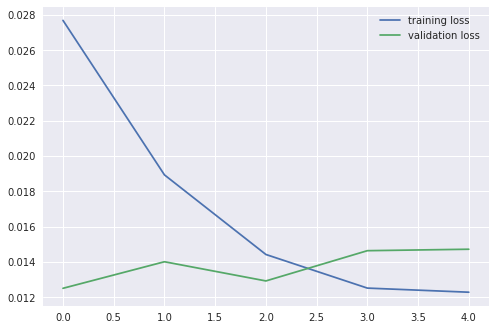

In [57]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

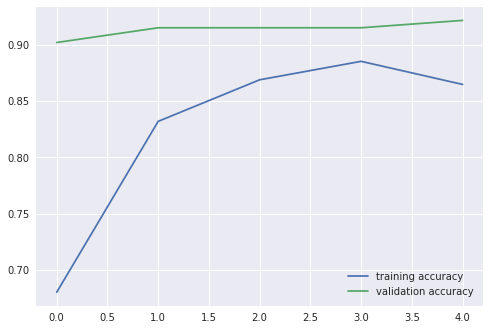

In [58]:
plt.plot(running_correct_history, label='training accuracy')
plt.plot(val_running_correct_history, label='validation accuracy')
plt.legend()

# test random images

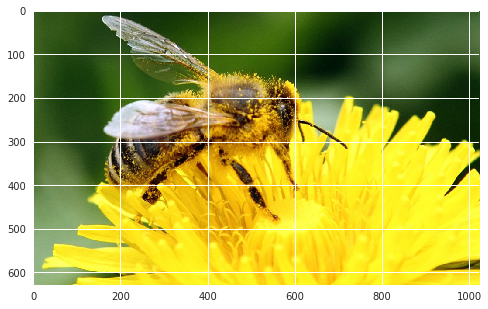

In [59]:
import PIL.ImageOps
import requests
from PIL import Image

url = 'https://d3i6fh83elv35t.cloudfront.net/newshour/app/uploads/2015/11/RTXZ3DT-e1487891078282-1024x629.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

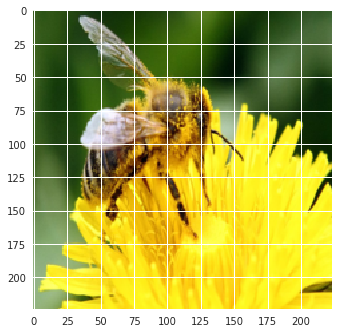

In [60]:
#Preprocessing
img = transform(img) 
plt.imshow(im_convert(img))

In [61]:
#predict
imgs = img.to(device).unsqueeze(0)
output = model(imgs)
_, pred = torch.max(output, 1)
print("Prediction: ", classes[pred.item()])

Prediction:  bee


IndexError: index 20 is out of bounds for dimension 0 with size 20

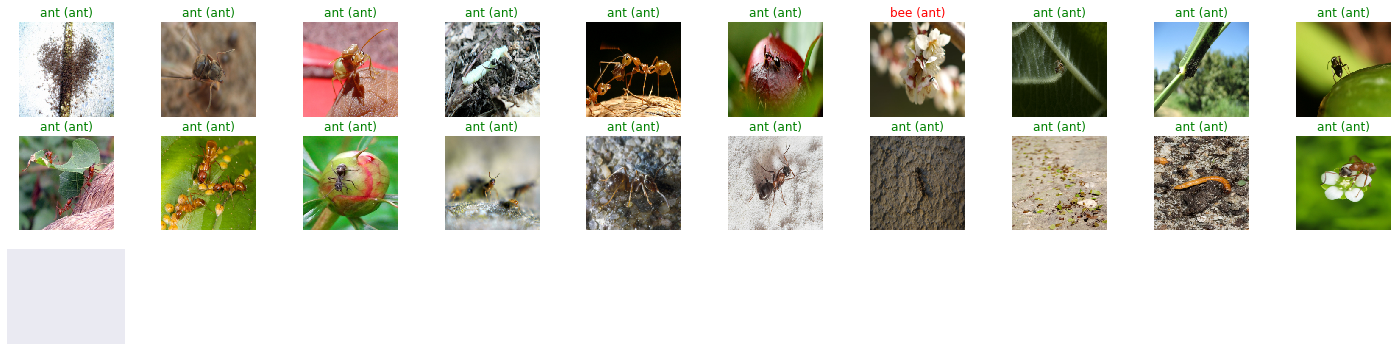

In [62]:
#predict all vals and print 20
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 8))

for idx in np.arange(40):
    ax = fig.add_subplot(4, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), 
                                  str(classes[labels[idx].item()])), 
                 color=("green" if preds[idx]==labels[idx] else "red"))

## example of too large learning rate, the gradient descent overshoot the minima: lr = 0.01

In [ ]:
plt.plot(running_loss_history, label='training loss')